<a href="https://colab.research.google.com/github/tanjummotin/Ice-cream-vs-pizza-classification-using-custom-CNN/blob/main/Ice_cream_vs_PIzza_classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 756.3 kB/s eta 0:00:00


In [5]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from google.colab.patches import cv2_imshow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tf_explain.core.grad_cam import GradCAM


In [6]:
# Path to the zipped dataset file in Google Drive
zip_path = '/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza.zip'

# Destination path to extract the dataset
extract_path = '/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza'


In [7]:
# Extract the dataset
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [8]:
# Set the path to the extracted dataset directory
dataset_path = os.path.join(extract_path, 'dataset/train')

# Initialize empty lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate over each subdirectory (each class)
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # Iterate over each image in the subdirectory
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)
            labels.append(class_name)


In [9]:
# Create a dataframe from file names and class labels
data = {'Filepath': image_paths, 'Class': labels}
df = pd.DataFrame(data)

# Extract class labels
class_labels = df['Class'].unique()

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Class'], random_state=42)

In [10]:
# Create an ImageDataGenerator with data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
# Flow the data for training from training dataframe
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="Filepath",
                                                    y_col="Class",
                                                    target_size=(128, 64),
                                                    color_mode='grayscale',
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

# Flow the data for validation from validation dataframe
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                x_col="Filepath",
                                                y_col="Class",
                                                target_size=(128, 64),
                                                color_mode='grayscale',
                                                batch_size=32,
                                                class_mode='binary',
                                                shuffle=False)



Found 574 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.


In [12]:
# Create a scratch CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [13]:
# Configure and compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=50,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples//val_generator.batch_size,
                    verbose=1)

Epoch 1/50
17/17 [==============================] - 16s 191ms/step - loss: 0.7311 - accuracy: 0.5258 - val_loss: 0.6813 - val_accuracy: 0.5391
Epoch 2/50
17/17 [==============================] - 3s 198ms/step - loss: 0.6759 - accuracy: 0.5867 - val_loss: 0.7684 - val_accuracy: 0.4609
Epoch 3/50
17/17 [==============================] - 3s 174ms/step - loss: 0.6675 - accuracy: 0.5941 - val_loss: 0.5737 - val_accuracy: 0.7500
Epoch 4/50
17/17 [==============================] - 4s 219ms/step - loss: 0.5829 - accuracy: 0.7159 - val_loss: 0.8784 - val_accuracy: 0.5625
Epoch 5/50
17/17 [==============================] - 3s 176ms/step - loss: 0.6309 - accuracy: 0.6882 - val_loss: 0.5048 - val_accuracy: 0.8047
Epoch 6/50
17/17 [==============================] - 3s 176ms/step - loss: 0.5259 - accuracy: 0.7528 - val_loss: 0.6516 - val_accuracy: 0.6719
Epoch 7/50
17/17 [==============================] - 3s 173ms/step - loss: 0.5478 - accuracy: 0.7306 - val_loss: 0.4681 - val_accuracy: 0.7578
Epoch

In [14]:
# Save the entire model
model.save('/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/saved_CNN_model.h5')

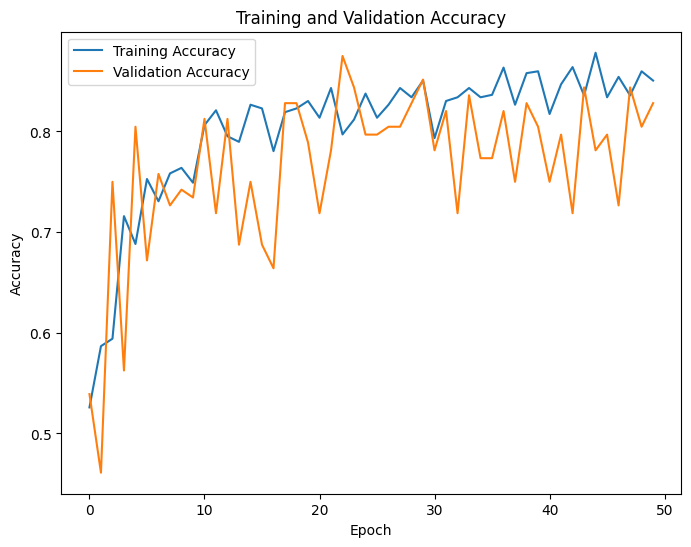

In [15]:
# Plot training and validation accuracy per epoch
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

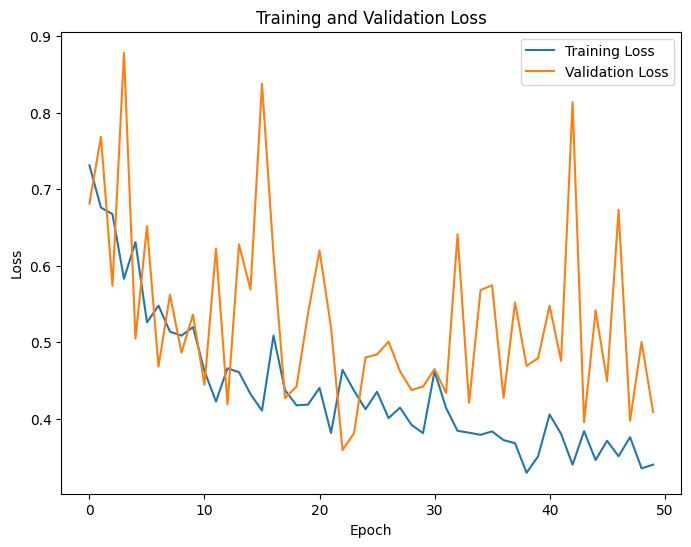

In [16]:
# Plot training and validation loss per epoch
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(val_generator)
print("Loss =", loss)
print("Accuracy =", accuracy)


5/5 [==============================] - 1s 116ms/step - loss: 0.4201 - accuracy: 0.8264
Loss = 0.42013120651245117
Accuracy = 0.8263888955116272


In [18]:
# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)



5/5 [==============================] - 1s 97ms/step
              precision    recall  f1-score   support

    icecream       0.86      0.81      0.83        78
       pizza       0.79      0.85      0.82        66

    accuracy                           0.83       144
   macro avg       0.83      0.83      0.83       144
weighted avg       0.83      0.83      0.83       144



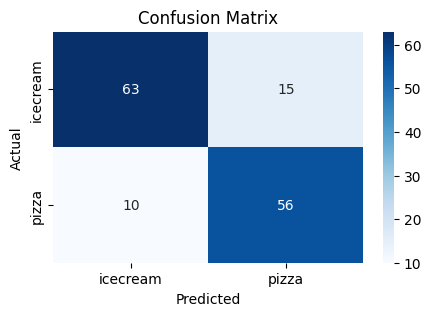

In [19]:
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap with labels and colored cells
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.5 MB/s eta 0:00:00


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 26880)             0         
                                                                 
 dense (Dense)               (None, 512)               1

In [22]:
def visualization_using_Gradcam(sample_image_path):
    # Load the model architecture and weights
  model = tf.keras.models.load_model('/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/saved_CNN_model.h5')

  sample_image = tf.keras.preprocessing.image.load_img(sample_image_path, color_mode='grayscale', target_size=(128, 64))
  sample_image_array = tf.keras.preprocessing.image.img_to_array(sample_image)
  sample_image_array /= 255.0  # Normalize the image array
  sample_image_array = np.expand_dims(sample_image_array, axis=0)

  # Get the model's prediction for the sample image
  prediction = model.predict(sample_image_array)
  predicted_class = "Pizza" if prediction[0][0] > 0.5 else "Ice Cream"

  # Create GradCAM instance
  explainer = GradCAM()

  # Choose the layer name to visualize the Grad-CAM. You can experiment with different layers.
  layer_name = 'conv2d_1'  # Change this to any Conv2D layer in your model
  # Calculate Grad-CAM heatmap
  grid = explainer.explain((sample_image_array, None), model, class_index=0, layer_name=layer_name) # Change class_index as needed.

  # Convert Grad-CAM heatmap to 2D array
  grid = np.squeeze(grid)

  # Plot the Grad-CAM heatmap over the original image
  plt.imshow(np.squeeze(sample_image_array), cmap='gray')
  plt.imshow(grid, alpha=0.6, cmap='jet')
  plt.title(f"Prediction: {predicted_class}")
  plt.axis('off')
  plt.show()


1/1 [==============================] - 0s 147ms/step


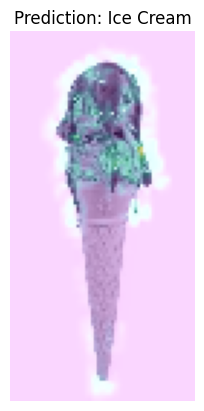

In [23]:
sample1 = '/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza/dataset/test/icecream/00616_jpg.rf.b90b7e2faf5db6d3b3e524471e04f989.jpg'
visualization_using_Gradcam(sample1)

1/1 [==============================] - 0s 82ms/step


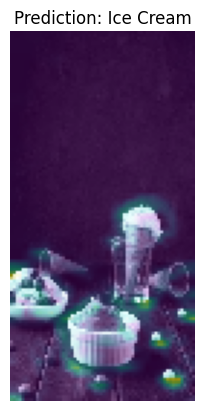

In [24]:
sample2 = '/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza/dataset/test/icecream/00124_jpg.rf.cbfd9b294fb345cac66fea8d648861dd.jpg'
visualization_using_Gradcam(sample2)

In [ ]:
sample3='/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza/dataset/test/icecream/00413_jpg.rf.23bd8aff75fd7b8395e5018bf2920194.jpg'
visualization_using_Gradcam(sample3)

1/1 [==============================] - 0s 77ms/step


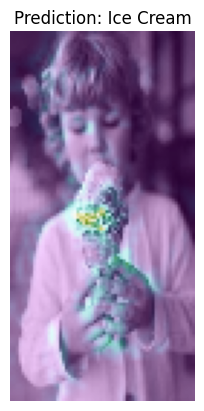

In [26]:
sample4='/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza/dataset/test/icecream/00605_jpg.rf.19e9376d1130ce0078d4944a07737adb.jpg'
visualization_using_Gradcam(sample4)

1/1 [==============================] - 0s 157ms/step


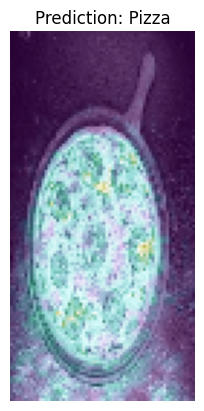

In [28]:
sample6='/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza/dataset/test/pizza/001_jpg.rf.47b37b36d16d0f7f69a8dfe20e82722a.jpg'
visualization_using_Gradcam(sample6)

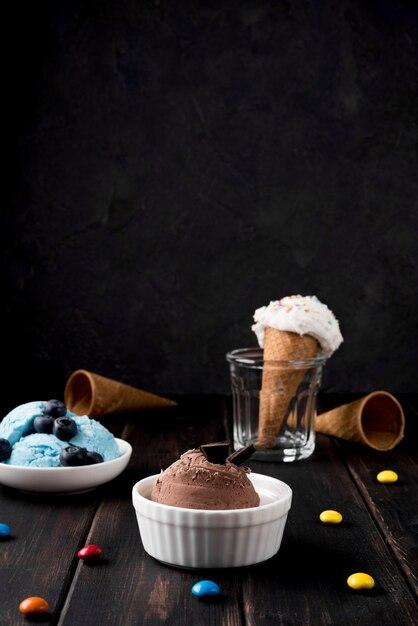

1/1 [==============================] - 0s 80ms/step
Predicted class: Ice cream


In [27]:
# Predict a single image using the model

single_image_path = '/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza/dataset/test/icecream/00124_jpg.rf.cbfd9b294fb345cac66fea8d648861dd.jpg'

single_image = cv2.imread(single_image_path, cv2.IMREAD_GRAYSCALE)
single_image = cv2.resize(single_image, (64, 128))
single_image = np.expand_dims(single_image, axis=-1)
single_image = np.expand_dims(single_image, axis=0)
single_image = single_image.astype('float32') / 255.0

cv2_imshow(cv2.imread(single_image_path))
prediction = model.predict(single_image)
if prediction[0][0] > 0.5:
    print("Predicted class: Pizza")
else:
    print("Predicted class: Ice cream")